In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
from mnist import MNIST
mndata = MNIST('./mnistdata')
Train_images, Train_labels = mndata.load_training()
Test_images, Test_labels = mndata.load_testing()

In [3]:
Train_X = np.array(Train_images[0:20000]).T
Train_Y = np.array(Train_labels[0:20000],ndmin=2)
Test_X = np.array(Test_images[-2000:]).T
Test_Y = np.array(Test_labels[-2000:],ndmin=2)

In [4]:
#extract 2 and 3 from training data
Train=np.concatenate((Train_X,Train_Y),axis=0)
df=pd.DataFrame(Train.T)
last_column = df.columns[-1]
df.rename(columns={last_column:'label'}, inplace=True)
index_2s = df['label'] == 2
index_3s = df['label'] == 3
Train_2_3 = df.loc[index_2s | index_3s]
Train_2_3_X=Train_2_3.drop(['label'],axis=1).as_matrix()
Train_2_3_Y=Train_2_3['label'].as_matrix()
Train_2_3_X=Train_2_3_X.T

In [5]:
#extract 2 and 3 from test data
Test=np.concatenate((Test_X,Test_Y),axis=0)
df_test=pd.DataFrame(Test.T)
last_column = df_test.columns[-1]
df_test.rename(columns={last_column:'label'}, inplace=True)
index_2s = df_test['label'] == 2
index_3s = df_test['label'] == 3
Test_2_3 = df_test.loc[index_2s | index_3s]
Test_2_3_X=Test_2_3.drop(['label'],axis=1).as_matrix()
Test_2_3_Y=Test_2_3['label'].as_matrix()
Test_2_3_X=Test_2_3_X.T

In [6]:
Train_2_3_Y=abs(Train_2_3_Y-3) ##change 2 to label 1, change 3 to label 0
Test_2_3_Y=abs(Test_2_3_Y-3)

In [7]:
# add bias to train and divide 255
Train_2_3_X=Train_2_3_X/255.0
Test_2_3_X=Test_2_3_X/255.0
one=np.ones((1,Train_2_3_X.shape[1]))
Train_2_3_X=np.concatenate((one,Train_2_3_X),axis=0)
one=np.ones((1,Test_2_3_X.shape[1]))
Test_2_3_X=np.concatenate((one,Test_2_3_X),axis=0)

In [8]:
#shuffle data
shuffle_index = list(np.random.permutation(Train_2_3_X.shape[1]))
Train_2_3_X = Train_2_3_X[:, shuffle_index]
Train_2_3_Y = Train_2_3_Y[shuffle_index]


In [9]:
Train_2_3_X.shape

(785, 4005)

In [10]:
##add hold out set
Train_2_3_X_hold = Train_2_3_X[:,Train_2_3_X.shape[1]/10*9:]
Train_2_3_X = Train_2_3_X[:,:Train_2_3_X.shape[1]/10*9]
Train_2_3_Y_hold = Train_2_3_Y[len(Train_2_3_Y)/10*9:]
Train_2_3_Y = Train_2_3_Y[:len(Train_2_3_Y)/10*9]
#w=np.random.randn(Train_2_3_X.shape[0],1)*0.001 # initialize weights
w=np.zeros((Train_2_3_X.shape[0],1))
Train_2_3_Y.reshape((1,len(Train_2_3_Y)))
Test_2_3_Y.reshape((1,len(Test_2_3_Y)))
print Train_2_3_X.shape , Train_2_3_X_hold.shape,Train_2_3_Y.shape,Train_2_3_Y_hold.shape

(785, 3600) (785, 405) (3600,) (405,)


In [11]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def cal_wx(w,x):
    return np.dot(w.T,x)

#y=sigmoid(cal_wx(w,x))

In [12]:
def cross_entropy(w,x,y):
    t=sigmoid(cal_wx(w,x)) # calculate activation
    cost_E= -1.0/(x.shape[1]) * np.sum(y*np.log(t)+(1-y)*np.log(1-t)) #calculate cost E
    dw = 1.0/(x.shape[1])*np.dot((y-t),x.T)
    return cost_E,dw

In [13]:
def mini_batches(x, y, mini_batch_size = 256):
    
    m = x.shape[1]                  
    mini_batches = []
        
    #calculate number of complete batches
    num_complete_minibatches = m//mini_batch_size 
    for k in range(0, num_complete_minibatches):
        mini_batch_x = x[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_y = y[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_x = x[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_y = y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [14]:
def optimize(w, x, y, x_hold,y_hold, num_iterations, learning_rate):
    costs = []
    costs_hold=[]
    for i in range(num_iterations):
        
        # Cost and gradient calculation (add regualarization)
        cost_E,dw=cross_entropy(w,x,y)   
        cost_E_hold,_=cross_entropy(w,x_hold,y_hold)
        
        # update weights
        w = w+learning_rate*dw.T
        learning_rate/=(1+i/1000)
        
        # Record the costs
        if i % 20 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            print ("Cost after iteration %i: %f" %(i, cost_E))
        
    return  w,costs,costs_hold

In [15]:
w=np.random.randn(Train_2_3_X.shape[0],1)*0.001 # initialize weights
def optimize_reg(w, x, y, x_hold,y_hold, x_test,y_test,num_iterations, learning_rate ,reg):
    costs = []
    costs_hold = []
    costs_test = []
    accuracy_train = []
    accuracy_hold = []
    accuracy_test = []
    for i in range(num_iterations):
        # Cost and gradient calculation (add regualarization)
        cost_E,dw=cross_entropy(w,x,y)   
        cost_E+=0.5*reg*np.sum(w**2)  # add regularization  
        dw+=reg*w.T
        
        #cost for hold out
        cost_E_hold,_=cross_entropy(w,x_hold,y_hold) 
        cost_E_hold += 0.5*reg*np.sum(abs(w))
        
        #cost for test
        cost_E_test,_=cross_entropy(w,x_test,y_test)
        cost_E_test += 0.5*reg*np.sum(abs(w))
        
        #update weights
        w = w+learning_rate*dw.T
        learning_rate/=(1+i/1000) #learning rate decay
        
        #calculate accuracy 
        _, acc_train = prediction(w,x,y)
        _, acc_hold = prediction(w,x_hold,y_hold)
        _, acc_test = prediction(w,x_test,y_test)

        

        # Record the costs and acc
        if i % 20 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            costs_test.append(cost_E_test)
            accuracy_train.append(acc_train)
            accuracy_hold.append(acc_hold)
            accuracy_test.append(acc_test)
            print "Train Cost after iteration %i: %f" %(i, cost_E)
            print "Accuracy for train is ", acc_train
           # print "Accuracy for hold is ", acc_hold
            #print "Accuracy for test is ", acc_test
            
        
    return  w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test

def prediction(w,x,y):
    prediction=sigmoid(cal_wx(w,x))
    predict=np.zeros_like(prediction)
    for index,number in enumerate(prediction[0]):
        if number>=0.5:
            predict[0,index]=1
        else:
            predict[0,index]=0
    #calculate accuracy
    correct = [(a==b) for (a,b) in zip(predict[0],y)]
    acc = sum(correct) * 1.0 / len(correct)
    return predict , acc

In [16]:
w=np.random.randn(Train_2_3_X.shape[0],1)*0.001 # initialize weights

def mini_optimize_reg(w, x, y, x_hold,y_hold, x_test,y_test,num_epochs, learning_rate ,reg,mini_batch_size=256):
    costs = []
    costs_hold = []
    costs_test = []
    accuracy_train = []
    accuracy_hold = []
    accuracy_test = []
    cost_epoch = []
    for i in range(num_epochs):
        
        minibatches = mini_batches(x, y, mini_batch_size )
        
        for minibatch in minibatches:
            (minibatch_x, minibatch_y) = minibatch
            _,dw=cross_entropy(w,minibatch_x,minibatch_y)   
            #cost_E+=0.5*reg*np.sum(w**2)  # add regularization  
            dw += reg*w.T
            
            #update weights
            w = w+learning_rate*dw.T
            learning_rate/=(1+i/1000) #learning rate decay
        

        # Cost for train
        cost_E,_ = cross_entropy(w,x,y)   
        cost_E += 0.5*reg*np.sum(w**2)
 
        
        #cost for hold out
        cost_E_hold,_=cross_entropy(w,x_hold,y_hold) 
        cost_E_hold += 0.5*reg*np.sum(w**2)
        
        #cost for test
        cost_E_test,_=cross_entropy(w,x_test,y_test)
        cost_E_test += 0.5*reg*np.sum(w**2)
    
        #early stop
    
        if i > 5:
            if cost_epoch[-5:] == sorted(cost_epoch[-5:]):
                break
        cost_epoch.append(cost_E_hold)       
        #calculate accuracy 
        _, acc_train = prediction(w,x,y)
        _, acc_hold = prediction(w,x_hold,y_hold)
        _, acc_test = prediction(w,x_test,y_test)

     
        # Record the costs and acc
        if i % 20 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            costs_test.append(cost_E_test)
            accuracy_train.append(acc_train)
            accuracy_hold.append(acc_hold)
            accuracy_test.append(acc_test)
            print "Train Cost after iteration %i: %f" %(i, cost_E)
            print "Accuracy for train is ", acc_train
           # print "Accuracy for hold is ", acc_hold
            #print "Accuracy for test is ", acc_test
            
        
    return  w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test

In [17]:
w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test=mini_optimize_reg(w, Train_2_3_X, Train_2_3_Y, Train_2_3_X_hold,Train_2_3_Y_hold, Test_2_3_X,Test_2_3_Y,num_epochs=1000, learning_rate=0.005 ,reg=0.01,mini_batch_size=256)

Train Cost after iteration 0: 0.614399
Accuracy for train is  0.917777777778
Train Cost after iteration 20: 0.245995
Accuracy for train is  0.942777777778
Train Cost after iteration 40: 0.192802
Accuracy for train is  0.948888888889
Train Cost after iteration 60: 0.170445
Accuracy for train is  0.951944444444
Train Cost after iteration 80: 0.157935
Accuracy for train is  0.953611111111
Train Cost after iteration 100: 0.149934
Accuracy for train is  0.956388888889
Train Cost after iteration 120: 0.144412
Accuracy for train is  0.957222222222
Train Cost after iteration 140: 0.140419
Accuracy for train is  0.957777777778
Train Cost after iteration 160: 0.137446
Accuracy for train is  0.958888888889
Train Cost after iteration 180: 0.135193
Accuracy for train is  0.96
Train Cost after iteration 200: 0.133473
Accuracy for train is  0.959722222222
Train Cost after iteration 220: 0.132163
Accuracy for train is  0.961944444444
Train Cost after iteration 240: 0.131177
Accuracy for train is  0.96

In [18]:
w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test = optimize_reg(w, Train_2_3_X, Train_2_3_Y, Train_2_3_X_hold,Train_2_3_Y_hold,Test_2_3_X,Test_2_3_Y, num_iterations= 500, learning_rate = 0.005,reg=0.0)

Train Cost after iteration 0: 0.111668
Accuracy for train is  0.964722222222
Train Cost after iteration 20: 0.111519
Accuracy for train is  0.964722222222
Train Cost after iteration 40: 0.111372
Accuracy for train is  0.965
Train Cost after iteration 60: 0.111227
Accuracy for train is  0.965
Train Cost after iteration 80: 0.111084
Accuracy for train is  0.965
Train Cost after iteration 100: 0.110942
Accuracy for train is  0.965277777778
Train Cost after iteration 120: 0.110802
Accuracy for train is  0.965277777778
Train Cost after iteration 140: 0.110662
Accuracy for train is  0.965277777778
Train Cost after iteration 160: 0.110525
Accuracy for train is  0.965277777778
Train Cost after iteration 180: 0.110388
Accuracy for train is  0.965277777778
Train Cost after iteration 200: 0.110252
Accuracy for train is  0.965277777778
Train Cost after iteration 220: 0.110117
Accuracy for train is  0.965277777778
Train Cost after iteration 240: 0.109983
Accuracy for train is  0.965277777778
Train 

In [18]:
predict_train, acc_train=prediction(w,Train_2_3_X,Train_2_3_Y)
#print "predict_train",  predict_train
print "acc_train", acc_train

predict_hold, acc_hold=prediction(w,Train_2_3_X_hold,Train_2_3_Y_hold)
print "acc_hold", acc_hold

predict_test, acc_test=prediction(w,Test_2_3_X,Test_2_3_Y)
#print "predict_test",  predict_test
print "acc_test", acc_test

acc_train 0.961111111111
acc_hold 0.962962962963
acc_test 0.967901234568


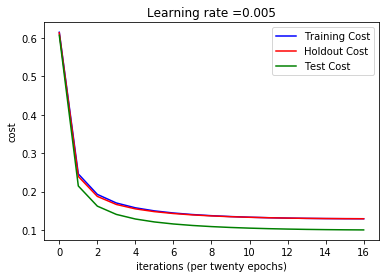

In [18]:
costs = np.squeeze(costs)
costs_hold = np.squeeze(costs_hold)
costs_test = np.squeeze(costs_test)
plt.plot(costs,color = 'blue',label='Training Cost')
plt.plot(costs_hold,color = 'red',label='Holdout Cost')
plt.plot(costs_test,color = 'green',label='Test Cost')
plt.ylabel('cost')
plt.xlabel('iterations (per twenty epochs)')
plt.title("Learning rate =" + str(0.005))
plt.legend()

plt.show()

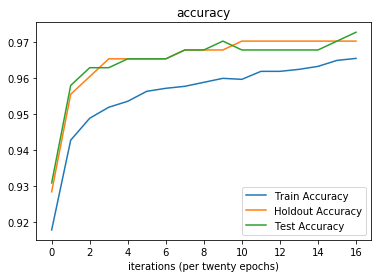

In [19]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_hold, label='Holdout Accuracy')
plt.plot(accuracy_test,label='Test Accuracy')

plt.xlabel('iterations (per twenty epochs)')
plt.title("accuracy")
plt.legend()
plt.show()

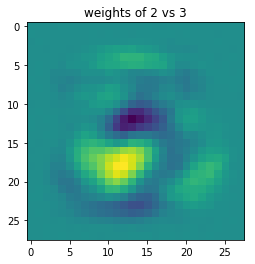

In [21]:
wp=w[1:].reshape((28,28))
plt.imshow(wp)
plt.title("weights of 2 vs 3")
plt.show()



In [22]:
#2 and 8
Train_X = np.array(Train_images[0:20000]).T
Train_Y = np.array(Train_labels[0:20000],ndmin=2)
Test_X = np.array(Test_images[-2000:]).T
Test_Y = np.array(Test_labels[-2000:],ndmin=2)

In [23]:
#extract 2 and 8 from training data
Train=np.concatenate((Train_X,Train_Y),axis=0)
df=pd.DataFrame(Train.T)
last_column = df.columns[-1]
df.rename(columns={last_column:'label'}, inplace=True)
index_2s = df['label'] == 2
index_8s = df['label'] == 8
Train_2_8 = df.loc[index_2s | index_8s]
Train_2_8_X=Train_2_8.drop(['label'],axis=1).as_matrix()
Train_2_8_Y=Train_2_8['label'].as_matrix()
Train_2_8_X=Train_2_8_X.T

In [24]:
#extract 2 and 8 from test data
Test=np.concatenate((Test_X,Test_Y),axis=0)
df_test=pd.DataFrame(Test.T)
last_column = df_test.columns[-1]
df_test.rename(columns={last_column:'label'}, inplace=True)
index_2s = df_test['label'] == 2
index_8s = df_test['label'] == 8
Test_2_8 = df_test.loc[index_2s | index_8s]
Test_2_8_X=Test_2_8.drop(['label'],axis=1).as_matrix()
Test_2_8_Y=Test_2_8['label'].as_matrix()
Test_2_8_X=Test_2_8_X.T

In [25]:
Train_2_8_Y=abs(Train_2_8_Y-8)/6 ##change 2 to label 1, change 3 to label 0
Test_2_8_Y=abs(Test_2_8_Y-8)/6

In [26]:
# add bias to train and divide 255
Train_2_8_X=Train_2_8_X/255.0
Test_2_8_X=Test_2_8_X/255.0
one=np.ones((1,Train_2_8_X.shape[1]))
Train_2_8_X=np.concatenate((one,Train_2_8_X),axis=0)
one=np.ones((1,Test_2_8_X.shape[1]))
Test_2_8_X=np.concatenate((one,Test_2_8_X),axis=0)

In [27]:
#shuffle data
shuffle_index = list(np.random.permutation(Train_2_8_X.shape[1]))
Train_2_8_X = Train_2_8_X[:, shuffle_index]
Train_2_8_Y = Train_2_8_Y[shuffle_index]

In [28]:
##add hold out set
Train_2_8_X_hold = Train_2_8_X[:,Train_2_8_X.shape[1]/10*9:]
Train_2_8_X = Train_2_8_X[:,:Train_2_8_X.shape[1]/10*9]
Train_2_8_Y_hold = Train_2_8_Y[len(Train_2_8_Y)/10*9:]
Train_2_8_Y = Train_2_8_Y[:len(Train_2_8)/10*9]
Train_2_8_Y.reshape((1,len(Train_2_8_Y)))
Test_2_8_Y.reshape((1,len(Test_2_8_Y)))
#w=np.random.randn(Train_2_8_X.shape[0],1)*0.0001 # initialize weights
w=np.zeros((Train_2_8_X.shape[0],1))
print Train_2_8_X.shape , Train_2_8_X_hold.shape,Train_2_8_Y.shape,Train_2_8_Y_hold.shape

(785, 3465) (785, 386) (3465,) (386,)


In [29]:
w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test = mini_optimize_reg(w, Train_2_8_X, Train_2_8_Y, Train_2_8_X_hold,Train_2_8_Y_hold,Test_2_8_X,Test_2_8_Y, num_epochs= 500, learning_rate = 0.005,reg=0.00,mini_batch_size=256)

Train Cost after iteration 0: 0.635672
Accuracy for train is  0.912842712843
Train Cost after iteration 20: 0.284967
Accuracy for train is  0.944877344877
Train Cost after iteration 40: 0.218268
Accuracy for train is  0.950649350649
Train Cost after iteration 60: 0.188612
Accuracy for train is  0.952092352092
Train Cost after iteration 80: 0.171223
Accuracy for train is  0.954978354978
Train Cost after iteration 100: 0.159533
Accuracy for train is  0.95670995671
Train Cost after iteration 120: 0.151006
Accuracy for train is  0.95873015873
Train Cost after iteration 140: 0.144437
Accuracy for train is  0.959018759019
Train Cost after iteration 160: 0.139178
Accuracy for train is  0.959884559885
Train Cost after iteration 180: 0.134842
Accuracy for train is  0.959595959596
Train Cost after iteration 200: 0.131186
Accuracy for train is  0.959884559885
Train Cost after iteration 220: 0.128048
Accuracy for train is  0.959595959596
Train Cost after iteration 240: 0.125314
Accuracy for train 

In [35]:
w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test = optimize_reg(w, Train_2_8_X, Train_2_8_Y, Train_2_8_X_hold,Train_2_8_Y_hold,Test_2_8_X,Test_2_8_Y, num_iterations= 800, learning_rate = 0.005,reg=0.0)

Train Cost after iteration 0: 0.693147
Accuracy for train is  0.92582972583
Train Cost after iteration 20: 0.612820
Accuracy for train is  0.934199134199
Train Cost after iteration 40: 0.550283
Accuracy for train is  0.937950937951
Train Cost after iteration 60: 0.500918
Accuracy for train is  0.938816738817
Train Cost after iteration 80: 0.461335
Accuracy for train is  0.940548340548
Train Cost after iteration 100: 0.429073
Accuracy for train is  0.94227994228
Train Cost after iteration 120: 0.402362
Accuracy for train is  0.943722943723
Train Cost after iteration 140: 0.379925
Accuracy for train is  0.943434343434
Train Cost after iteration 160: 0.360830
Accuracy for train is  0.9443001443
Train Cost after iteration 180: 0.344388
Accuracy for train is  0.9443001443
Train Cost after iteration 200: 0.330083
Accuracy for train is  0.944588744589
Train Cost after iteration 220: 0.317521
Accuracy for train is  0.945454545455
Train Cost after iteration 240: 0.306397
Accuracy for train is  

In [30]:
predict_train, acc_train=prediction(w,Train_2_8_X,Train_2_8_Y)
#print "predict_train",  predict_train
print "acc_train", acc_train

predict_hold, acc_hold=prediction(w,Train_2_8_X_hold,Train_2_8_Y_hold)
print "acc_hold", acc_hold

predict_test, acc_test=prediction(w,Test_2_8_X,Test_2_8_Y)
#print "predict_test",  predict_test
print "acc_test", acc_test

acc_train 0.963636363636
acc_hold 0.966321243523
acc_test 0.961038961039


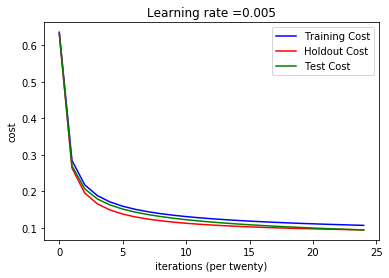

In [31]:
costs = np.squeeze(costs)
costs_hold = np.squeeze(costs_hold)
costs_test = np.squeeze(costs_test)
costs_test = np.squeeze(costs_test)
plt.plot(costs,color = 'blue',label='Training Cost')
plt.plot(costs_hold,color = 'red',label='Holdout Cost')
plt.plot(costs_test,color = 'green',label='Test Cost')
plt.ylabel('cost')
plt.xlabel('iterations (per twenty)')
plt.title("Learning rate =" + str(0.005))
plt.legend()

plt.show()

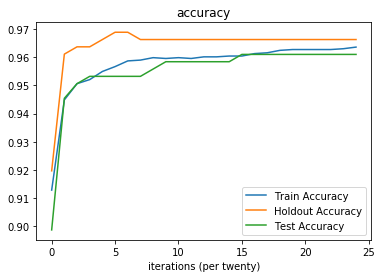

In [32]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_hold, label='Holdout Accuracy')
plt.plot(accuracy_test,label='Test Accuracy')
plt.xlabel('iterations (per twenty)')
plt.title("accuracy")
plt.legend()
plt.show()

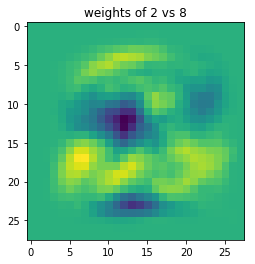

In [33]:
wp8=w[1:].reshape((28,28))
plt.imshow(wp8)
plt.title("weights of 2 vs 8")
plt.show()

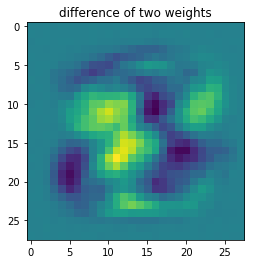

In [34]:
wp28=wp-wp8
plt.imshow(wp28)
plt.title("difference of two weights")
plt.show()

In [15]:
#softmax
Train_X = np.array(Train_images[0:20000]).T
Train_Y = np.array(Train_labels[0:20000])
Test_X = np.array(Test_images[-2000:]).T
Test_Y = np.array(Test_labels[-2000:])


In [16]:
# add bias to train and divide 255
Train_X=Train_X/255.0
Test_X=Test_X/255.0
one=np.ones((1,Train_X.shape[1]))
Train_X=np.concatenate((one,Train_X),axis=0)
one=np.ones((1,Test_X.shape[1]))
Test_X=np.concatenate((one,Test_X),axis=0)

In [17]:
#shuffle data
shuffle_index = list(np.random.permutation(Train_X.shape[1]))
Train_X = Train_X[:, shuffle_index]
Train_Y = Train_Y[shuffle_index]

In [18]:
##add hold out set
Train_X_hold = Train_X[:,Train_X.shape[1]/10*9:]
Train_X = Train_X[:,:Train_X.shape[1]/10*9]
Train_Y_hold = Train_Y[len(Train_Y)/10*9:]
Train_Y = Train_Y[:len(Train_Y)/10*9]
w=np.random.randn(Train_X.shape[0],10)*0.001 # initialize weights
Train_Y.reshape((1,len(Train_Y)))
Test_Y.reshape((1,len(Test_Y)))
print Train_X.shape , Train_X_hold.shape,Train_Y.shape,Train_Y_hold.shape

(785, 18000) (785, 2000) (18000,) (2000,)


In [19]:
def softmax(a):
    a-=np.max(a,axis=0,keepdims=True) #stabilize
    sum_a=np.sum(np.exp(a),axis=0,keepdims=True)
    y_k= np.exp(a)/sum_a
    return y_k

def build_mask(y):
    
    mask=np.zeros((10,len(y)))
    mask[y,np.arange(len(y))] = 1
    
    return mask

def cross_entro_soft(x,y,w):
    
    a= np.dot(w.T,x)
    mask = build_mask(y)
    y_k = softmax(a)
    E = -np.sum(np.log(y_k[y,np.arange(x.shape[1])]))/x.shape[1]/10
    
    
    dw= 1.0*np.dot((mask-y_k),x.T)/x.shape[1]
    
    return E,dw

def predict_softmax(w,x,y):
    a= np.dot(w.T,x)
    y_k = softmax(a)
    y_pred = y_k.argmax(axis=0)
    correct = [(a==b) for (a,b) in zip(y_pred,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc
    

In [20]:
def optimize_reg_softmax(w, x, y,x_hold,y_hold,x_test,y_test, num_iterations, learning_rate ,reg):
    costs = []
    costs_hold = []
    costs_test = []
    accuracy_train = []
    accuracy_hold = []
    accuracy_test = []
    
    for i in range(num_iterations):
    
        # Cost and gradient calculation (add regualarization)
        cost_E,dw=cross_entro_soft(x,y,w)
        cost_E+=0.5*reg*np.sum(w**2)
        dw+=reg*w.T
        
        #cost for hold out
        cost_E_hold,_=cross_entro_soft(x_hold,y_hold,w) 
        cost_E_hold += 0.5*reg*np.sum(w**2)
        
        #cost for test
        cost_E_test,_=cross_entro_soft(x_test,y_test,w)
        cost_E_test += 0.5*reg*np.sum(w**2)
        
        #calculate accuracy 
        acc_train = predict_softmax(w,x,y)
        acc_hold = predict_softmax(w,x_hold,y_hold)
        acc_test = predict_softmax(w,x_test,y_test)

        #update weights
        w = w+learning_rate*dw.T
        
        #learning rate decay
        learning_rate/=(1+i/1000) 

        # Record the costs
        if i % 100 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            costs_test.append(cost_E_test)
            accuracy_train.append(acc_train)
            accuracy_hold.append(acc_hold)
            accuracy_test.append(acc_test)
            
            print ("Cost after iteration %i: %f" %(i, cost_E))
        
    return  w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test

In [90]:
w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test=optimize_reg_softmax(w, Train_X, Train_Y,Train_X_hold,Train_Y_hold,Test_X,Test_Y, num_iterations=500, learning_rate=0.001 ,reg=0.01)

Cost after iteration 0: 0.230316
Cost after iteration 100: 0.219897
Cost after iteration 200: 0.210425
Cost after iteration 300: 0.201763
Cost after iteration 400: 0.193830


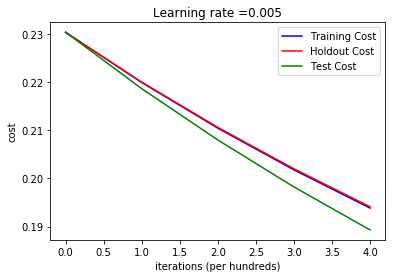

In [91]:
costs = np.squeeze(costs)
costs_hold = np.squeeze(costs_hold)
costs_test = np.squeeze(costs_test)
costs_test = np.squeeze(costs_test)
plt.plot(costs,color = 'blue',label='Training Cost')
plt.plot(costs_hold,color = 'red',label='Holdout Cost')
plt.plot(costs_test,color = 'green',label='Test Cost')
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(0.005))
plt.legend()

plt.show()

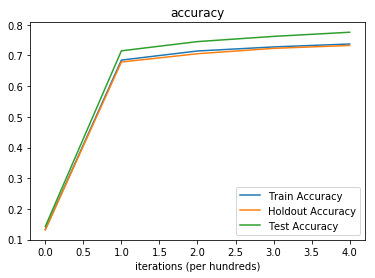

In [92]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_hold, label='Holdout Accuracy')
plt.plot(accuracy_test,label='Test Accuracy')
plt.xlabel('iterations (per hundreds)')
plt.title("accuracy")
plt.legend()
plt.show()

In [21]:
w=np.random.randn(Train_X.shape[0],10)*0.001 # initialize weights

def mini_optimize_reg_softmax(w, x, y, x_hold,y_hold, x_test,y_test,num_epochs, learning_rate ,reg,mini_batch_size=1024):
    costs = []
    costs_hold = []
    costs_test = []
    accuracy_train = []
    accuracy_hold = []
    accuracy_test = []
    cost_epoch = []
    for i in range(num_epochs):
        
        minibatches = mini_batches(x, y, mini_batch_size )
        
        for minibatch in minibatches:
            (minibatch_x, minibatch_y) = minibatch
            _,dw=cross_entro_soft(minibatch_x,minibatch_y,w)   
            #cost_E+=0.5*reg*np.sum(w**2)  # add regularization  
            dw += reg*w.T
            
            #updata gradients and learning rate decay
            w = w+learning_rate*dw.T
            learning_rate/=(1+i/1000) #learning rate decay
        

        # Cost for train
        cost_E,_ = cross_entro_soft(x,y,w)   
        cost_E += 0.5*reg*np.sum(w**2) #L2
        #cost_E += 0.5*reg*np.sum(abs(w)) #L1
 
        
        #cost for hold out
        cost_E_hold,_=cross_entro_soft(x_hold,y_hold,w) 
        cost_E_hold += 0.5*reg*np.sum(w**2) #L2
        #cost_E_hold += 0.5*reg*np.sum(abs(w)) #L1
        
        #cost for test
        cost_E_test,_=cross_entro_soft(x_test,y_test,w)
        cost_E_test += 0.5*reg*np.sum(w**2) #L2
        #cost_E_test += 0.5*reg*np.sum(abs(w)) #L1
        
        #calculate accuracy 
        acc_train = predict_softmax(w,x,y)
        acc_hold = predict_softmax(w,x_hold,y_hold)
        acc_test = predict_softmax(w,x_test,y_test)

        cost_epoch.append(cost_E_hold)
        
        #early stop
        if i > 5:
            if cost_epoch[-5:] == sorted(cost_epoch[-5:]):
                break
        

        # Record the costs and acc
        if i % 20 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            costs_test.append(cost_E_test)
            accuracy_train.append(acc_train)
            accuracy_hold.append(acc_hold)
            accuracy_test.append(acc_test)
            print "Train Cost after iteration %i: %f" %(i, cost_E)
            print "Accuracy for train is ", acc_train
           # print "Accuracy for hold is ", acc_hold
            #print "Accuracy for test is ", acc_test
            
        
    return  w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test

In [22]:
w,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test=mini_optimize_reg_softmax(w, Train_X, Train_Y,Train_X_hold,Train_Y_hold,Test_X,Test_Y, num_epochs=1000, learning_rate=0.005 ,reg=0.0001,mini_batch_size=1024)

Train Cost after iteration 0: 0.220642
Accuracy for train is  0.688944444444
Train Cost after iteration 20: 0.121872
Accuracy for train is  0.799
Train Cost after iteration 40: 0.091038
Accuracy for train is  0.828666666667
Train Cost after iteration 60: 0.076860
Accuracy for train is  0.843833333333
Train Cost after iteration 80: 0.068643
Accuracy for train is  0.853944444444
Train Cost after iteration 100: 0.063219
Accuracy for train is  0.859888888889
Train Cost after iteration 120: 0.059335
Accuracy for train is  0.865222222222
Train Cost after iteration 140: 0.056397
Accuracy for train is  0.868055555556
Train Cost after iteration 160: 0.054083
Accuracy for train is  0.872222222222
Train Cost after iteration 180: 0.052206
Accuracy for train is  0.874944444444
Train Cost after iteration 200: 0.050647
Accuracy for train is  0.877777777778
Train Cost after iteration 220: 0.049328
Accuracy for train is  0.8805
Train Cost after iteration 240: 0.048193
Accuracy for train is  0.882166666

In [163]:
predict_softmax(w,Train_X,Train_Y)

0.90927777777777774

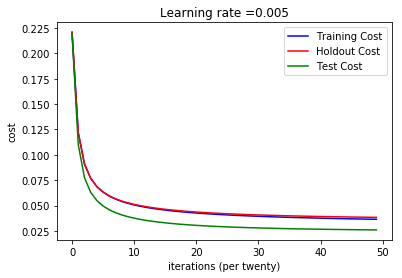

In [164]:
costs = np.squeeze(costs)
costs_hold = np.squeeze(costs_hold)
costs_test = np.squeeze(costs_test)
plt.plot(costs,color = 'blue',label='Training Cost')
plt.plot(costs_hold,color = 'red',label='Holdout Cost')
plt.plot(costs_test,color = 'green',label='Test Cost')
plt.ylabel('cost')
plt.xlabel('iterations (per twenty)')
plt.title("Learning rate =" + str(0.005))
plt.legend()

plt.show()

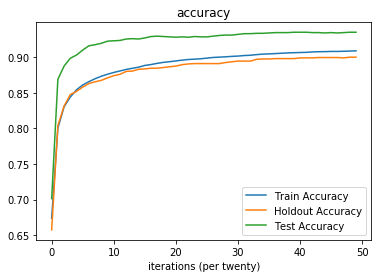

In [165]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_hold, label='Holdout Accuracy')
plt.plot(accuracy_test,label='Test Accuracy')
plt.xlabel('iterations (per twenty)')
plt.title("accuracy")
plt.legend()
plt.show()

In [167]:
print accuracy_train[-1]
print accuracy_hold[-1]
print accuracy_test[-1]

0.908944444444
0.9
0.935


In [111]:
a=w[:,0][1:].reshape((28,28))

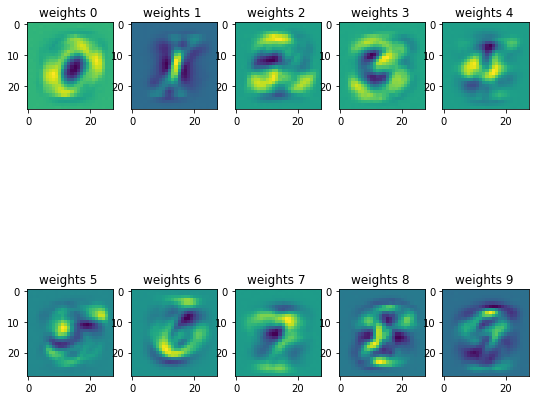

In [123]:
fig = plt.figure(figsize=(9, 9))
plt.subplot(2, 5, 1)
plt.imshow(w[:,0][1:].reshape((28,28)))
plt.title("weights 0 ")
plt.subplot(2, 5, 2)
plt.imshow(w[:,1][1:].reshape((28,28)))
plt.title("weights 1 ")
plt.subplot(2, 5, 3)
plt.imshow(w[:,2][1:].reshape((28,28)))
plt.title("weights 2 ")
plt.subplot(2, 5, 4)
plt.imshow(w[:,3][1:].reshape((28,28)))
plt.title("weights 3 ")
plt.subplot(2, 5, 5)
plt.imshow(w[:,4][1:].reshape((28,28)))
plt.title("weights 4 ")
plt.subplot(2, 5, 6)
plt.imshow(w[:,5][1:].reshape((28,28)))
plt.title("weights 5 ")
plt.subplot(2, 5, 7)
plt.imshow(w[:,6][1:].reshape((28,28)))
plt.title("weights 6 ")
plt.subplot(2, 5, 8)
plt.imshow(w[:,7][1:].reshape((28,28)))
plt.title("weights 7 ")
plt.subplot(2, 5, 9)
plt.imshow(w[:,8][1:].reshape((28,28)))
plt.title("weights 8 ")
plt.subplot(2, 5, 10)
plt.imshow(w[:,9][1:].reshape((28,28)))
plt.title("weights 9 ")
plt.show()

In [149]:
Train_X = np.array(Train_images[0:20000]).T
Train_Y = np.array(Train_labels[0:20000],ndmin=2)
Train=np.concatenate((Train_X,Train_Y),axis=0)
df=pd.DataFrame(Train.T)
last_column = df.columns[-1]
df.rename(columns={last_column:'label'}, inplace=True)
index_0s = df['label'] == 0
Train_0 = df.loc[index_0s]
Train_0_X=Train_0.drop(['label'],axis=1).as_matrix()
Train_0_X=Train_0_X.T
index_1s = df['label'] == 1
Train_1 = df.loc[index_1s]
Train_1_X=Train_1.drop(['label'],axis=1).as_matrix()
Train_1_X=Train_1_X.T
index_2s = df['label'] == 2
Train_2 = df.loc[index_2s]
Train_2_X=Train_2.drop(['label'],axis=1).as_matrix()
Train_2_X=Train_2_X.T
index_3s = df['label'] == 3
Train_3 = df.loc[index_3s]
Train_3_X=Train_3.drop(['label'],axis=1).as_matrix()
Train_3_X=Train_3_X.T
index_4s = df['label'] == 4
Train_4 = df.loc[index_4s]
Train_4_X=Train_4.drop(['label'],axis=1).as_matrix()
Train_4_X=Train_4_X.T
index_5s = df['label'] == 5
Train_5 = df.loc[index_5s]
Train_5_X=Train_5.drop(['label'],axis=1).as_matrix()
Train_5_X=Train_5_X.T
index_6s = df['label'] == 6
Train_6 = df.loc[index_6s]
Train_6_X=Train_6.drop(['label'],axis=1).as_matrix()
Train_6_X=Train_6_X.T
index_7s = df['label'] == 7
Train_7 = df.loc[index_7s]
Train_7_X=Train_7.drop(['label'],axis=1).as_matrix()
Train_7_X=Train_7_X.T
index_8s = df['label'] == 8
Train_8 = df.loc[index_8s]
Train_8_X=Train_8.drop(['label'],axis=1).as_matrix()
Train_8_X=Train_8_X.T
index_9s = df['label'] == 9
Train_9 = df.loc[index_9s]
Train_9_X=Train_9.drop(['label'],axis=1).as_matrix()
Train_9_X=Train_9_X.T

In [150]:
Train_0_X=Train_0_X/255.0
Train_0_X_average=np.sum(Train_0_X,axis=1)/Train_1_X.shape[1]
Train_1_X=Train_1_X/255.0
Train_1_X_average=np.sum(Train_1_X,axis=1)/Train_1_X.shape[1]
Train_2_X=Train_2_X/255.0
Train_2_X_average=np.sum(Train_2_X,axis=1)/Train_2_X.shape[1]
Train_3_X=Train_3_X/255.0
Train_3_X_average=np.sum(Train_3_X,axis=1)/Train_3_X.shape[1]
Train_4_X=Train_4_X/255.0
Train_4_X_average=np.sum(Train_4_X,axis=1)/Train_4_X.shape[1]
Train_5_X=Train_5_X/255.0
Train_5_X_average=np.sum(Train_5_X,axis=1)/Train_5_X.shape[1]
Train_6_X=Train_6_X/255.0
Train_6_X_average=np.sum(Train_6_X,axis=1)/Train_6_X.shape[1]
Train_7_X=Train_7_X/255.0
Train_7_X_average=np.sum(Train_7_X,axis=1)/Train_7_X.shape[1]
Train_8_X=Train_8_X/255.0
Train_8_X_average=np.sum(Train_8_X,axis=1)/Train_8_X.shape[1]
Train_9_X=Train_9_X/255.0
Train_9_X_average=np.sum(Train_9_X,axis=1)/Train_9_X.shape[1]


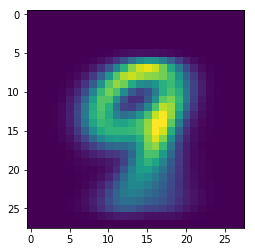

In [148]:
plt.imshow(Train_9_X_average.reshape((28,28)))
plt.show()

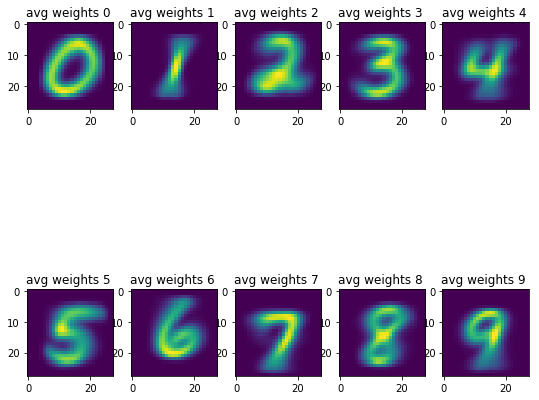

In [153]:
fig = plt.figure(figsize=(9, 9))
plt.subplot(2, 5, 1)
plt.imshow(Train_0_X_average.reshape((28,28)))
plt.title("avg weights 0 ")
plt.subplot(2, 5, 2)
plt.imshow(Train_1_X_average.reshape((28,28)))
plt.title("avg weights 1 ")
plt.subplot(2, 5, 3)
plt.imshow(Train_2_X_average.reshape((28,28)))
plt.title("avg weights 2 ")
plt.subplot(2, 5, 4)
plt.imshow(Train_3_X_average.reshape((28,28)))
plt.title("avg weights 3 ")
plt.subplot(2, 5, 5)
plt.imshow(Train_4_X_average.reshape((28,28)))
plt.title("avg weights 4 ")
plt.subplot(2, 5, 6)
plt.imshow(Train_5_X_average.reshape((28,28)))
plt.title("avg weights 5 ")
plt.subplot(2, 5, 7)
plt.imshow(Train_6_X_average.reshape((28,28)))
plt.title("avg weights 6 ")
plt.subplot(2, 5, 8)
plt.imshow(Train_7_X_average.reshape((28,28)))
plt.title("avg weights 7 ")
plt.subplot(2, 5, 9)
plt.imshow(Train_8_X_average.reshape((28,28)))
plt.title("avg weights 8 ")
plt.subplot(2, 5, 10)
plt.imshow(Train_9_X_average.reshape((28,28)))
plt.title("avg weights 9 ")
plt.show()

In [26]:
w[:,0]

array([ -1.55685593e-01,  -3.66767125e-04,   5.40713490e-04,
         1.78094659e-03,   4.60904977e-04,  -2.56277277e-05,
        -1.18184480e-03,  -4.42298756e-04,  -1.01134065e-03,
        -1.68022280e-04,   5.79938316e-04,  -1.43768308e-03,
         2.32223616e-03,   1.08520645e-03,   9.33741586e-04,
        -1.36768843e-03,  -3.00996331e-04,   1.68583978e-03,
        -8.24778314e-04,   2.95360028e-04,   7.08782933e-04,
         1.24369352e-04,  -4.83864995e-04,  -1.00864395e-03,
         7.10776823e-04,   7.39275506e-04,   2.47341039e-04,
        -5.12441290e-04,   3.36895720e-04,  -1.02952475e-04,
        -1.36860427e-03,   3.19470614e-03,  -6.33481340e-04,
         1.80593915e-03,  -1.23802274e-03,   6.01139496e-04,
        -5.19758216e-04,  -6.97195986e-05,   1.22421592e-03,
         1.54320759e-04,  -2.03431584e-03,  -1.46358110e-03,
        -1.43689142e-03,  -1.83950537e-03,   1.03705022e-03,
         5.29154854e-03,   1.95887347e-03,   8.85176286e-04,
        -1.14183161e-04,